In [1]:
import random
import time

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import torch

from vladk_neural_network.model.activation import LeakyRelu, Linear
from vladk_neural_network.model.base import NeuralNetwork
from vladk_neural_network.model.layer import FullyConnected, Input
from vladk_neural_network.model.loss import CategoricalCrossEntropy
from vladk_neural_network.model.metric import AccuracyOneHot
from vladk_neural_network.model.optimizer import Adam

## Helper functions for displaying changes in loss and Accuracy with the change of epochs

In [2]:
def plot_loss(epoch, train_loss, test_loss, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_loss, color='r', label='Train')
    plt.plot(epoch, test_loss, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_accuracy_score(epoch, train_metric, test_metric, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_metric, color='r', label='Train')
    plt.plot(epoch, test_metric, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

# 1. Classification on full iris dataset

## Function to display selected iris sample data with species shown on the sepal width - sepal height and petal width - petal height coordinates

In [3]:
def plot_iris(data, title):

    sepal_length, sepal_width, petal_length, petal_width, colors = [], [], [], [], []

    for row in data:
        sepal_length.append(row['input'][0])
        sepal_width.append(row['input'][1])
        petal_length.append(row['input'][2])
        petal_width.append(row['input'][3])
        if row['output'] == [1.0, 0.0, 0.0]:
            color = 'red'
        elif row['output'] == [0.0, 1.0, 0.0]:
            color = 'blue'
        else:
            color = 'orange'
        colors.append(color)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.scatter(sepal_length, sepal_width, c=colors, alpha=0.5)
    red_patch = mpatches.Patch(color='red', label='Iris-setosa')
    blue_patch = mpatches.Patch(color='blue', label='Iris-versicolor')
    orange_patch = mpatches.Patch(color='orange', label='Iris-virginica')
    ax1.legend(handles=[red_patch, blue_patch, orange_patch], title="Species")
    ax1.set_title(f"{title} in sepal coordinates")
    ax1.set_xlabel("sepal_length")
    ax1.set_ylabel("sepal_width")

    ax2.scatter(petal_length, petal_width, c=colors, alpha=0.5)
    ax2.legend(handles=[red_patch, blue_patch, orange_patch], title="Species")
    ax2.set_title(f"{title} in petal coordinates")
    ax2.set_xlabel("petal_length")
    ax2.set_ylabel("petal_width")

    plt.tight_layout()
    plt.show()

    return

## Function to obtain an iris dataset

In [4]:
def get_iris_dataset():
    data = pd.read_csv('../data/iris/Iris.csv')
    data.drop('Id', axis=1, inplace=True)
    feature_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
    for feature_column in feature_columns:
        data[feature_column] = (data[feature_column] - data[feature_column].min())/(data[feature_column].max() - data[feature_column].min())

    one_hot_map = {
        'Iris-setosa': [1.0, 0.0, 0.0],
        'Iris-versicolor': [0.0, 1.0, 0.0],
        'Iris-virginica': [0.0, 0.0, 1.0],
    }

    dataset = []
    for index in data.index:
        input_values = [float(val) for val in data.loc[index].drop('Species').values]
        specie = one_hot_map[data.loc[index, 'Species']]
        dataset.append({
            'input': input_values,
            'output': specie
        })

    random.shuffle(dataset)
    return dataset[:115], dataset[115:]

## Create model for classification on iris dataset and test

Epoch: 1/30, train loss: 0.8755, train Accuracy: 0.7391, test loss: 0.8038, test Accuracy: 0.9143, epoch time: 0.11s
Epoch: 2/30, train loss: 0.7507, train Accuracy: 0.8609, test loss: 0.7017, test Accuracy: 0.9714, epoch time: 0.092s
Epoch: 3/30, train loss: 0.6798, train Accuracy: 0.9478, test loss: 0.59, test Accuracy: 0.9714, epoch time: 0.095s
Epoch: 4/30, train loss: 0.6448, train Accuracy: 0.9043, test loss: 0.6243, test Accuracy: 0.9429, epoch time: 0.092s
Epoch: 5/30, train loss: 0.6312, train Accuracy: 0.9304, test loss: 0.633, test Accuracy: 0.9429, epoch time: 0.092s
Epoch: 6/30, train loss: 0.6281, train Accuracy: 0.9217, test loss: 0.6621, test Accuracy: 0.9143, epoch time: 0.091s
Epoch: 7/30, train loss: 0.6316, train Accuracy: 0.9391, test loss: 0.6184, test Accuracy: 0.9429, epoch time: 0.091s
Epoch: 8/30, train loss: 0.6154, train Accuracy: 0.9652, test loss: 0.5991, test Accuracy: 0.9714, epoch time: 0.09s
Epoch: 9/30, train loss: 0.619, train Accuracy: 0.9391, test 

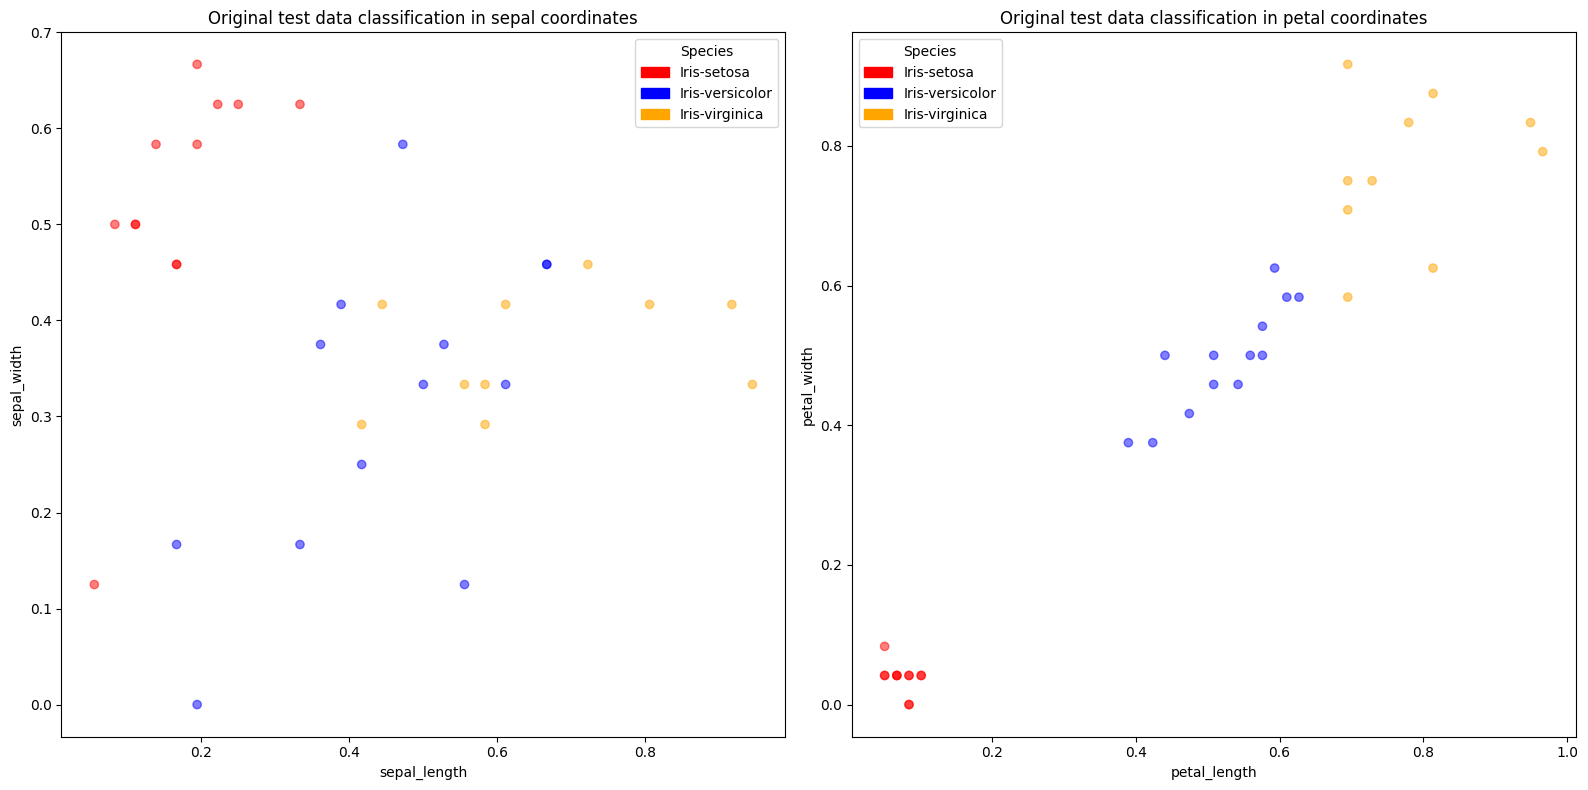

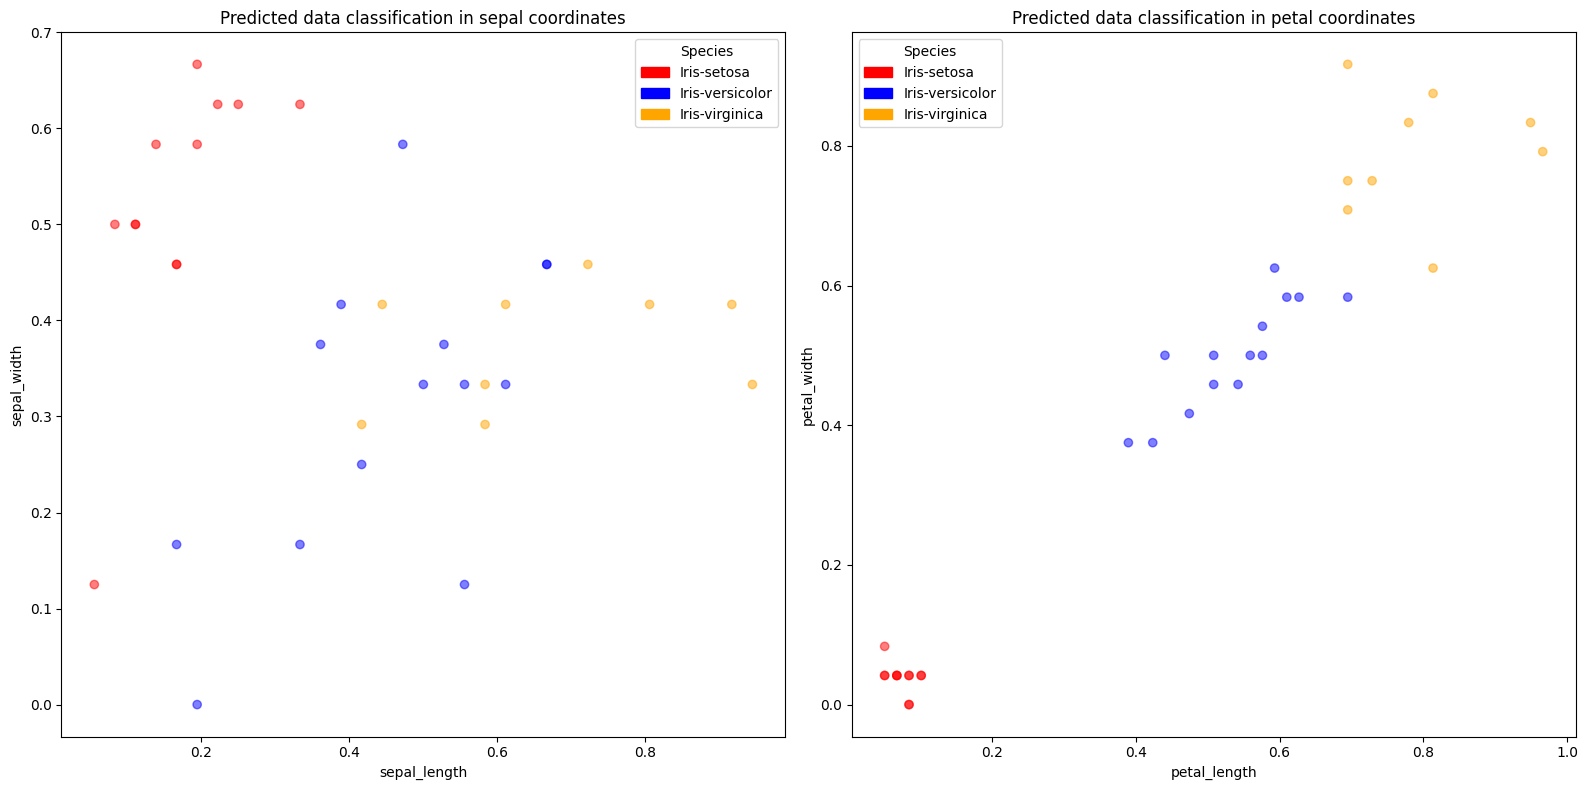

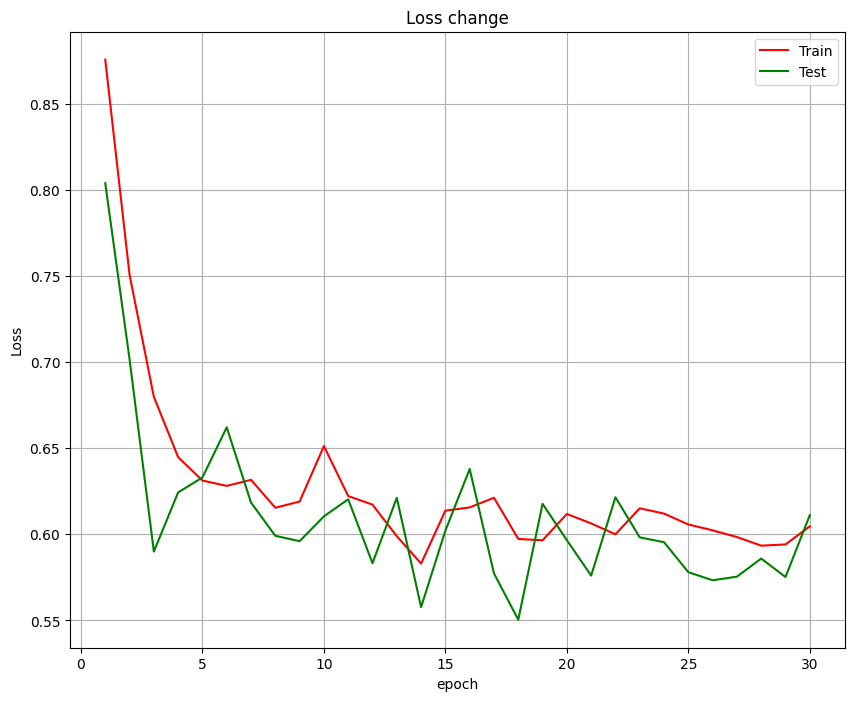

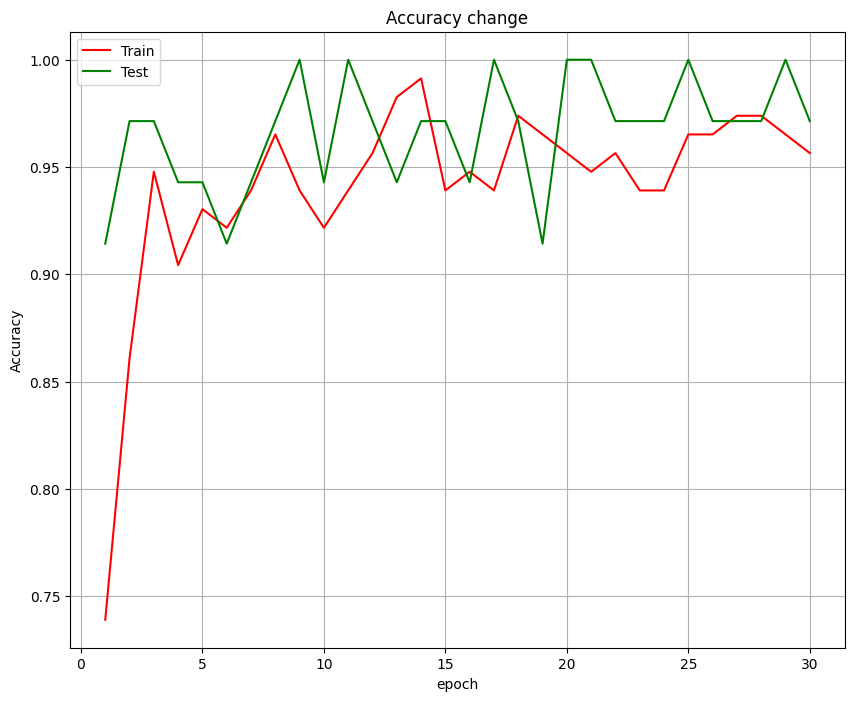

In [5]:
train_dataset, test_dataset = get_iris_dataset()

start_time = time.time()

layers = [
    FullyConnected(128, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(3, Linear())
]
nn = NeuralNetwork(
    Input(4),
    layers,
    optimizer=Adam(),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction='argmax'
)

epochs = 30
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=1, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction, raw_pred = nn.predict(test_dataset, with_raw_prediction=True)

predicted = test_dataset.copy()

predicted = []
for index, predict in enumerate(prediction):
    predicted.append({
        'input': test_dataset[index]['input'],
        'output': predict.flatten().tolist()
    })

plot_iris(test_dataset, 'Original test data classification')
plot_iris(predicted, 'Predicted data classification')

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change")

# 2. Classification on digits dataset

## Function to display selected digit

In [6]:
def plot_digit(image, digit):
    image = torch.tensor(image).numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted digit: {digit}")
    plt.axis("off")
    plt.show()

    return

## Helper function to get one-hot array for digit

In [7]:
def get_onehot_digit(digit):
    output = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return output[-digit:] + output[:-digit]

## Helper function to get digit by one-hot arrary

In [8]:
def get_digit(onehot_array):
    for index, value in enumerate(onehot_array):
        if value == 1.0:
            return index
    return None

## Function to get digits train/test data

In [9]:
def get_digits_data():

    train_dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=5000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        train_dataset.append(
            {
                "input": input_values,
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    random.seed(1)
    random.shuffle(train_dataset)
    return train_dataset[:2000], train_dataset[2000:2500]

## Create model for classification on digits dataset and test

Epoch: 1/20, train loss: 2.091, train Accuracy: 0.6025, test loss: 1.8443, test Accuracy: 0.854, epoch time: 1.237s
Epoch: 2/20, train loss: 1.8053, train Accuracy: 0.866, test loss: 1.7165, test Accuracy: 0.902, epoch time: 1.244s
Epoch: 3/20, train loss: 1.7179, train Accuracy: 0.912, test loss: 1.6781, test Accuracy: 0.928, epoch time: 1.291s
Epoch: 4/20, train loss: 1.6702, train Accuracy: 0.936, test loss: 1.6461, test Accuracy: 0.938, epoch time: 1.2s
Epoch: 5/20, train loss: 1.6367, train Accuracy: 0.953, test loss: 1.6225, test Accuracy: 0.942, epoch time: 1.202s
Epoch: 6/20, train loss: 1.6091, train Accuracy: 0.966, test loss: 1.6179, test Accuracy: 0.942, epoch time: 1.216s
Epoch: 7/20, train loss: 1.5911, train Accuracy: 0.9735, test loss: 1.6077, test Accuracy: 0.934, epoch time: 1.22s
Epoch: 8/20, train loss: 1.5743, train Accuracy: 0.981, test loss: 1.5963, test Accuracy: 0.942, epoch time: 1.445s
Epoch: 9/20, train loss: 1.559, train Accuracy: 0.9875, test loss: 1.5854,

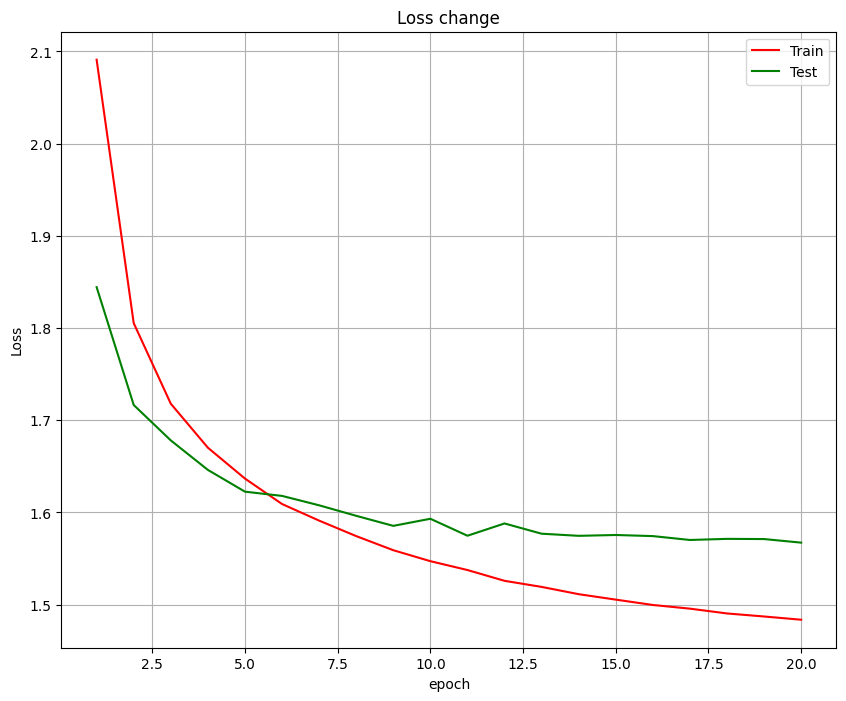

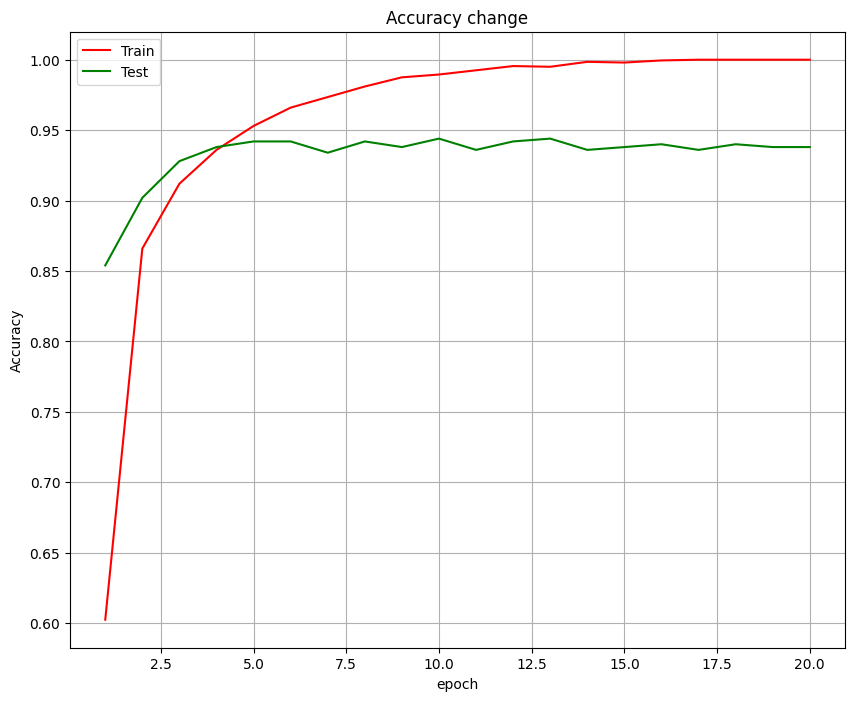

In [10]:
train_dataset, test_dataset = get_digits_data()

layers = [
    FullyConnected(256, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(64, LeakyRelu()),
    FullyConnected(10, Linear()),
]
nn = NeuralNetwork(
    Input(784),
    layers,
    optimizer=Adam(),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction="argmax",
)

start_time = time.time()

epochs = 20
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=8, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = nn.predict(test_dataset)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change")

## First ten test digits with predicted values

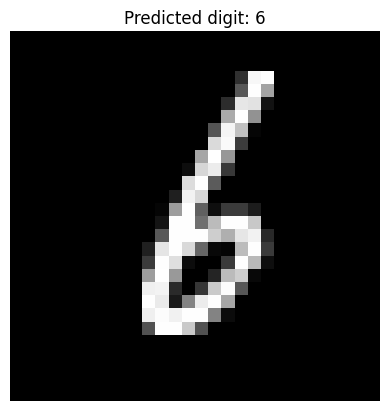

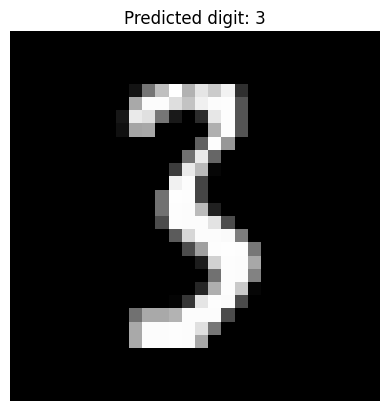

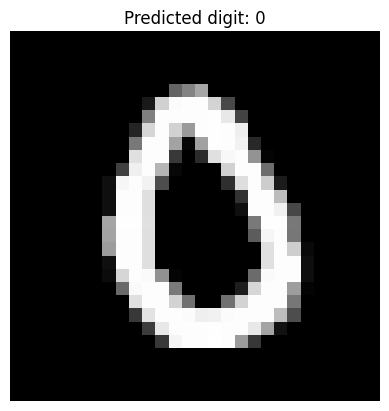

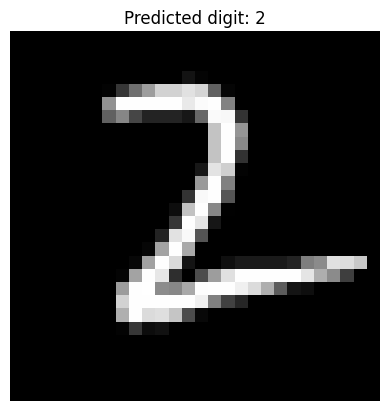

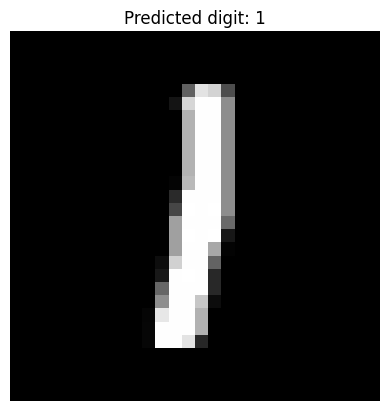

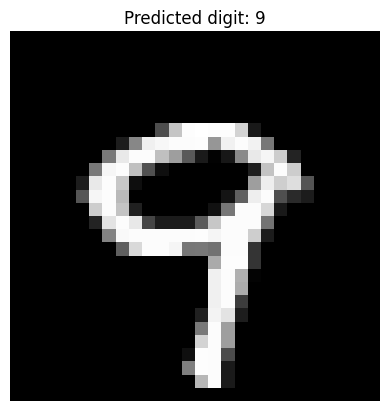

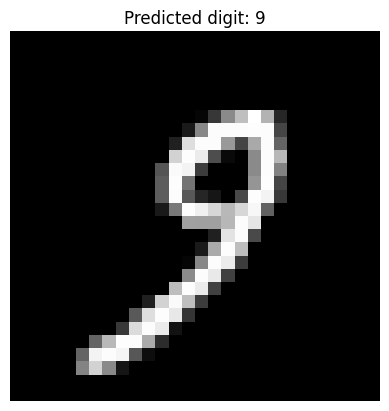

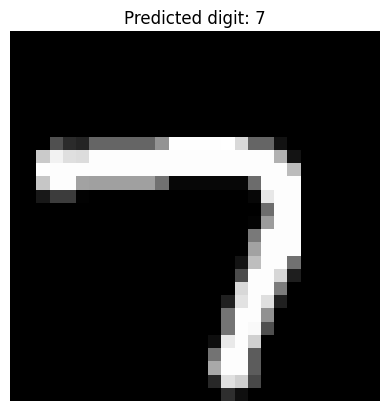

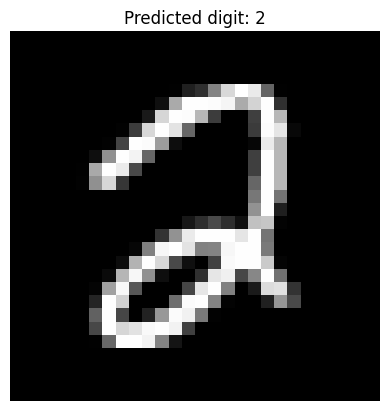

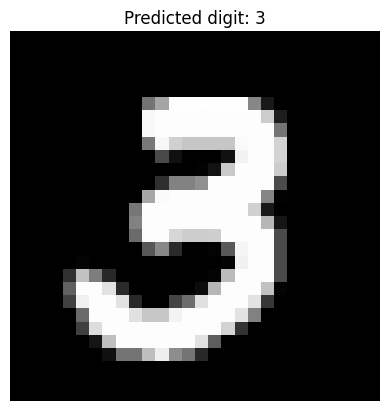

In [11]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit(test_dataset[index]['input'], get_digit(predicted_digit))